In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "tilebox",
#     "xarray",
#     "matplotlib",
#     "ipywidgets",
#     "sgp4",
#     "openmeteo-requests",
#     "requests-cache",
#     "retry-requests",
#     "numpy",
#     "shapely",
# ]
# ///

<img src="https://uploads-ssl.webflow.com/64b58e06654493327b4a59ee/6508a6973bb25aebe94d4fde_tilebox-color.svg" alt="Tilebox" width="200"/>

# Challenge 3: Mini-Constellation Tasking Planner

This notebook provides a starting point for the challenge. It covers:

- How to load [WorldView Legion TLEs](https://console.tilebox.com/datasets/explorer/9dd28d78-20ad-4ef5-841b-9a9f94506a68) from Tilebox into an xarray dataset and plot their orbits.
- How to fetch cloud cover forecast data from [OpenMeteo](https://open-meteo.com/)
- How the tasking order interface **could** look like
    - area of interest
    - time range
    - imaging constraint parameters
        - maximum cloud cover
        - off-nadir angle
        - sun altitude

**Tilebox docs available at**: [docs.tilebox.com](https://docs.tilebox.com/)

Join us on Discord: <a href="https://tilebox.com/discord">
<img src="https://img.shields.io/badge/Discord-%235865F2.svg?style=flat-square&logo=discord&logoColor=white" alt="Join us on Discord"/>
</a>

## Dependencies

Install [uv](https://docs.astral.sh/uv/) and then launch this notebook with:

```bash
uvx juv run Mini_Constellation_Tasking_Planner_Challenge.ipynb
```

(The `uvx` command is included when installing `uv`).

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
from sgp4.api import WGS72, Satrec
from sgp4.conveniences import jday
from tilebox.datasets import Client

# Fetch latest Legion constellation TLEs

In [ ]:
# Create your key here: https://console.tilebox.com/account/api-keys
client = Client(token="<YOUR_TILEBOX_API_KEY>")
legion_dataset = client.dataset("open_data.space_track.worldview_legion_tles")

tle_data = []
sat_names = []

# Fetch TLE data for all 6 LEGION satellites
for satellite_name in ("LEGION 1", "LEGION 2", "LEGION 3", "LEGION 4", "LEGION 5", "LEGION 6"):
    print(f"Fetching TLE data for {satellite_name}...")
    collection = legion_dataset.collection(satellite_name)
    data = collection.query(temporal_extent=("2025-11-01", "2025-12-01"), show_progress=True)

    if len(data.time) > 0:
        # Get the most recent TLE (last time index)
        tle_line1 = data.tle_line1.values[-1]
        tle_line2 = data.tle_line2.values[-1]
        object_name = data.object_name.values[-1]

        tle_data.append((tle_line1, tle_line2))
        sat_names.append(object_name)
        print(f"  ✓ Found {len(data.time)} TLEs, using most recent from {data.time.values[-1]}")
    else:
        print(f"  ✗ No TLE data found for {satellite_name}")

Fetching TLE data for LEGION 1...
  ✓ Found 25 TLEs, using most recent from 2025-11-08T23:16:50.000000000
Fetching TLE data for LEGION 2...
  ✓ Found 24 TLEs, using most recent from 2025-11-08T23:16:50.000000000
Fetching TLE data for LEGION 3...
  ✓ Found 22 TLEs, using most recent from 2025-11-08T23:16:50.000000000
Fetching TLE data for LEGION 4...
  ✓ Found 23 TLEs, using most recent from 2025-11-08T23:16:50.000000000
Fetching TLE data for LEGION 5...
  ✓ Found 17 TLEs, using most recent from 2025-11-08T23:16:50.000000000
Fetching TLE data for LEGION 6...
  ✓ Found 14 TLEs, using most recent from 2025-11-08T15:16:39.000000000


## Define propagation time range

In [3]:
# Create satellite objects
satellites = [Satrec.twoline2rv(l1, l2, WGS72) for l1, l2 in tle_data]

# Propagation start time (UTC) - using a recent date that aligns with TLE data
start_time = datetime(2025, 11, 10, 12, 0, 0)
duration_hours = 2  # Duration of propagation
time_step_seconds = 300  # Calculate position every 5 minutes (300 seconds)

# Generate an array of time steps (seconds)
time_steps_np = np.arange(0, duration_hours * 3600, time_step_seconds)

# Generate an array of datetime objects for propagation
times = [start_time + timedelta(seconds=float(dt)) for dt in time_steps_np]

# Convert datetime objects to Julian Date (jd) and fractional day (fr)
jd_array, fr_array = zip(
    *[jday(t.year, t.month, t.day, t.hour, t.minute, t.second + t.microsecond / 1e6) for t in times], strict=False
)

## Propagate and collect positions

In [4]:
# Dictionary to store positions for each satellite
positions_eci = {name: [] for name in sat_names}

for i, sat in enumerate(satellites):
    name = sat_names[i]

    error, r_array, v_array = sat.sgp4_array(np.array(jd_array), np.array(fr_array))

    # r_array contains (x, y, z) positions in kilometers in the TEME (ECI) frame
    valid_positions = r_array[error == 0]
    positions_eci[name] = valid_positions

## Plot the orbits in 3D

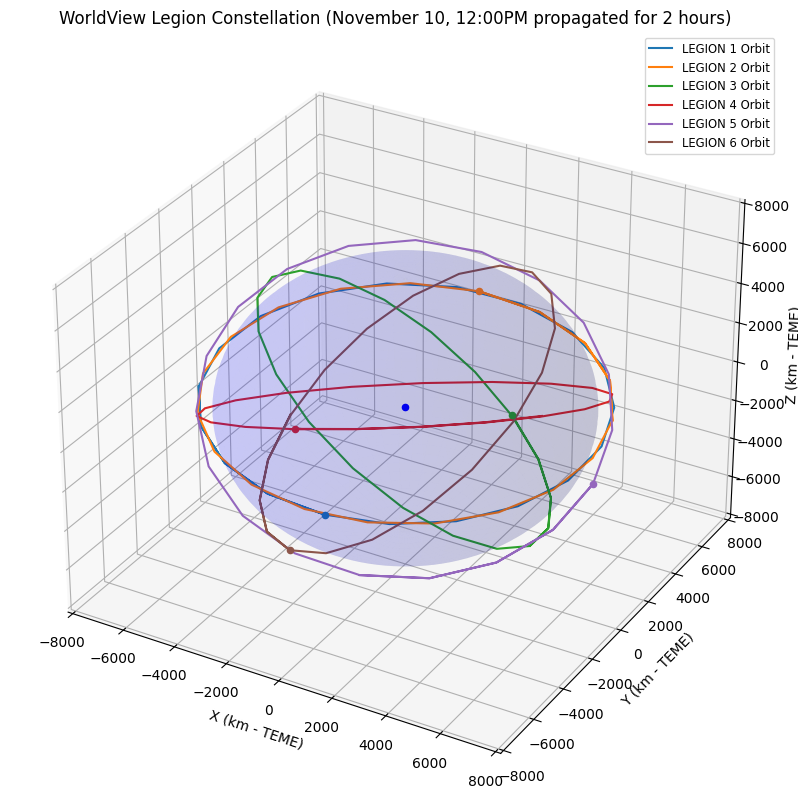

In [5]:
# The Earth's mean radius in km (for plotting)
EARTH_RADIUS_KM = 6371.0

fig = plt.figure(figsize=(12, 10))
# Create a 3D subplot
ax = fig.add_subplot(111, projection="3d")

# Plot the Earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_earth = EARTH_RADIUS_KM * np.outer(np.cos(u), np.sin(v))
y_earth = EARTH_RADIUS_KM * np.outer(np.sin(u), np.sin(v))
z_earth = EARTH_RADIUS_KM * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot Earth surface
ax.plot_surface(x_earth, y_earth, z_earth, color="blue", alpha=0.1, linewidth=0)
# Plot Earth center
ax.scatter(0, 0, 0, color="blue", marker="o")

# Plot Satellite Orbits
all_coords = []
for name, pos_list in positions_eci.items():
    if len(pos_list) > 0:
        pos = np.array(pos_list)
        x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]

        # Plot the orbit line
        ax.plot(x, y, z, label=f"{name} Orbit", linewidth=1.5)
        # Plot the current (last) position of the satellite
        ax.scatter(x[-1], y[-1], z[-1], marker="o", label=f"{name} Current")

        # Collect all coordinates to set limits
        all_coords.append(pos)

# Configure Plot View

ax.set_title(f"WorldView Legion Constellation ({start_time.strftime('%B %d, %I:%M%p')} propagated for {duration_hours} hours)")
# The SGP4 output is in the TEME frame (Earth-Centered Inertial)
ax.set_xlabel("X (km - TEME)")
ax.set_ylabel("Y (km - TEME)")
ax.set_zlabel("Z (km - TEME)")

# Set equal aspect ratio for a proper 3D view
max_range = 0
if all_coords:
    all_coords_array = np.vstack(all_coords)
    max_val = np.max(np.abs(all_coords_array))
    # Add a buffer for plot boundaries
    max_range = max(max_val, EARTH_RADIUS_KM) * 1.2
else:
    max_range = EARTH_RADIUS_KM * 1.5

# Set limits to be symmetrical around zero
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

# Filter to only show the "Orbit" line in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = {label: handle for handle, label in zip(handles, labels, strict=False) if "Orbit" in label}
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper right", fontsize="small")

plt.show()


## Fetch Cloud cover over a set of locations

**Open-Meteo API docs**: [https://open-meteo.com/en/docs/dwd-api](https://open-meteo.com/en/docs/dwd-api)

In [6]:
from datetime import datetime, timedelta, timezone

import openmeteo_requests
import requests_cache
import xarray as xr
from retry_requests import retry

In [7]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Query the api for 3 locations
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": [52.52, 50.12, 53.55],
    "longitude": [13.41, 8.68, 9.99],
    "hourly": ["cloud_cover", "cloud_cover_low", "cloud_cover_high", "cloud_cover_mid"],
    "models": "icon_seamless",
}
responses = openmeteo.weather_api(url, params=params)

In [8]:
# Process locations responses
for response in responses:
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_cloud_cover = hourly.Variables(0).ValuesAsNumpy()
    hourly_cloud_cover_low = hourly.Variables(1).ValuesAsNumpy()
    hourly_cloud_cover_high = hourly.Variables(2).ValuesAsNumpy()
    hourly_cloud_cover_mid = hourly.Variables(3).ValuesAsNumpy()

    # Create time coordinate
    start_time = datetime.fromtimestamp(hourly.Time(), tz=timezone.utc)
    end_time = datetime.fromtimestamp(hourly.TimeEnd(), tz=timezone.utc)
    interval_seconds = hourly.Interval()
    num_steps = int((hourly.TimeEnd() - hourly.Time()) / interval_seconds)
    time_coords = [start_time + timedelta(seconds=i * interval_seconds) for i in range(num_steps)]

    # Create dataset
    hourly_dataset = xr.Dataset(
        data_vars={
            "cloud_cover": (["time"], hourly_cloud_cover),
            "cloud_cover_low": (["time"], hourly_cloud_cover_low),
            "cloud_cover_high": (["time"], hourly_cloud_cover_high),
            "cloud_cover_mid": (["time"], hourly_cloud_cover_mid),
        },
        coords={
            "time": time_coords,
        },
    )
    print(hourly_dataset, "\n")

Coordinates: 52.52000045776367°N 13.419998168945312°E
<xarray.Dataset> Size: 4kB
Dimensions:           (time: 168)
Coordinates:
  * time              (time) object 1kB 2025-11-18T00:00:00+00:00 ... 2025-11...
Data variables:
    cloud_cover       (time) float32 672B 0.0 32.0 74.0 97.0 ... 100.0 99.0 97.0
    cloud_cover_low   (time) float32 672B 0.0 32.0 20.0 72.0 ... 0.0 31.0 63.0
    cloud_cover_high  (time) float32 672B 0.0 0.0 0.0 16.0 ... 100.0 68.0 37.0
    cloud_cover_mid   (time) float32 672B 0.0 0.0 61.0 86.0 ... 100.0 95.0 91.0 

Coordinates: 50.119998931884766°N 8.680000305175781°E
<xarray.Dataset> Size: 4kB
Dimensions:           (time: 168)
Coordinates:
  * time              (time) object 1kB 2025-11-18T00:00:00+00:00 ... 2025-11...
Data variables:
    cloud_cover       (time) float32 672B 0.0 94.0 67.0 ... 100.0 99.0 99.0
    cloud_cover_low   (time) float32 672B 0.0 0.0 0.0 59.0 ... 79.0 83.0 88.0
    cloud_cover_high  (time) float32 672B 0.0 94.0 67.0 ... 100.0 67.0 33.0

## Example Tasking Order

Below `dataclass` gives you an idea what a tasking order for your constellation tasking planner **could** look like.

In [ ]:
import json
from datetime import datetime
from shapely.geometry import shape
from shapely import Geometry
from pathlib import Path
from dataclasses import dataclass

In [ ]:
@dataclass
class TaskingOrder:
    area_of_interest: Geometry
    time_range: tuple[datetime, datetime]
    max_cloud_cover_percentage: float | None
    off_nadir_angle_range: tuple[float, float] | None
    solar_zenith_angle_range: tuple[float, float] | None

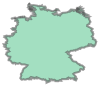

In [30]:
# download country-level GeoJSON from https://geojson-maps.kyd.au/

germany = shape(json.loads(Path("germany.json").read_text())["features"][0])
germany

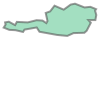

In [ ]:
austria = shape(json.loads(Path("austria.json").read_text())["features"][0])
austria

In [ ]:
tasking_orders = [
    TaskingOrder(  # first tasking order
        # capture images over germany
        area_of_interest=germany,
        # on the weekend of September 21st-23rd
        time_range=(datetime(2025, 11, 21), datetime(2025, 11, 23)),
        # require cloud cover of 10% or less
        max_cloud_cover_percentage=10,
        # and an off nadir angle between 0-30 degrees
        off_nadir_angle_range=(0, 30),
        # and a solar zenith angle between 0-60 degrees for optimal daylight images
        solar_zenith_angle_range=(0, 60)
    ),
    TaskingOrder(  # second tasking order
        # capture images over austria
        area_of_interest=austria,
        # on August 16th from 2pm to 4pm
        time_range=(datetime(2025, 8, 16, 14, 0), datetime(2025, 8, 16, 16, 0)),
        # require cloud cover of 40% or less
        max_cloud_cover_percentage=40,
        # irregardless of nadir angle
        off_nadir_angle_range=None,
        # and a solar zenith angle between 0-60 degrees for optimal daylight images
        solar_zenith_angle_range=(0, 60)
    )
]

### Off nadir angle

Off Nadir Angle (ONA) is the angle between the satellite’s nadir, which is directly below the satellite, and the point on the Earth’s surface which is being observed.

### Solar zenith angle

The angle between the sun's rays and the vertical direction (zenith). 0° is directly overhead, and 90° is on the horizon.

![](https://skyfisupport.zendesk.com/hc/article_attachments/29800385785620)